# Query Sentinel-2 images

In this notebook we will show how to query Sentinel-2 images over an area between two given dates. We will use the `sentinelsat` package to obtain the Sentinel-2 product names and we will read those from the [public GCP bucket](https://cloud.google.com/storage/docs/public-datasets/sentinel-2) (`gs://gcp-public-data-sentinel-2/tiles`).

Set the env variables to be able to read from the Google bucket. This  will incur in reading costs.

In [1]:
import os
import datetime
from shapely.geometry import box
import geopandas as gpd

# Donwload key from next line link to access the buckets and requester pays requests to public bucket (this is needed to query Sentinel-2 data)
# https://console.cloud.google.com/iam-admin/serviceaccounts/details/113408056464434182094/keys?authuser=1&project=cs-starcop-dtacs&supportedpurview=project
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/home/gonzalo/Downloads/cs-starcop-dtacs-620b59dd7276.json"
os.environ["GS_USER_PROJECT"] = "cs-starcop-dtacs"

### Step 1: Select dates and area of interest to read

In [12]:
# from georeader.rasterio_reader import RasterioReader
# reader = RasterioReader("gs://starcop/Permian/permian_2019_official/ang20190928t185111-4_r6871_c424_rgb.tif")
# crs_bounds = reader.crs
# bounds_read = reader.bounds

In [24]:
import rasterio.warp
bounds_read = (593234.590889374, 3520212.5018222863, 593481.795237977, 3520573.2886527125)
crs_bounds = "EPSG:32613"

bounds_read_latlong = rasterio.warp.transform_bounds(crs_bounds, "EPSG:4326", *bounds_read)
polygon_read = box(*bounds_read_latlong)

datetime_str = "20190928t185111"
date_of_interest = datetime.datetime.strptime(datetime_str, "%Y%m%dt%H%M%S")

date_start_search = date_of_interest - datetime.timedelta(days=10)
date_end_search = date_of_interest + datetime.timedelta(days=10)

print(f"Querying images between {date_start_search} and {date_end_search}\nArea: {polygon_read}")

Querying images between 2019-09-18 18:51:11 and 2019-10-08 18:51:11
Area: POLYGON ((-104.01228597233182 31.813715155134062, -104.01228597233182 31.816989958320846, -104.01493211463453 31.816989958320846, -104.01493211463453 31.813715155134062, -104.01228597233182 31.813715155134062))


### Step 2: Query the products

In [25]:
from sentinelsat.sentinel import SentinelAPI
# 'https://scihub.copernicus.eu/apihub'
api = SentinelAPI('gonzmg88', "Gdz44cWAZzfxtNC", api_url='https://scihub.copernicus.eu/dhus/')

In [26]:
%%time
from georeader.readers import S2_SAFE_reader

# Query the S2 images available in that period
products = api.query(area=str(polygon_read),
                     date=(date_start_search, date_end_search),
                     platformname='Sentinel-2',
                     producttype='S2MSI1C',
                     cloudcoverpercentage=(0, 80))
products_gpd = api.to_geodataframe(products)

# Set the tile name
products_gpd["mgrs_tile"] = products_gpd.title.apply(lambda x: S2_SAFE_reader.s2_name_split(x)[5])

# Compute the overlap of the product with the AoI polygon

products_gpd["overlappercentage"] = products_gpd.geometry.apply(lambda x: x.intersection(polygon_read).area / polygon_read.area * 100)
products_gpd[["title", "mgrs_tile", "overlappercentage","cloudcoverpercentage", "datatakesensingstart", "geometry"]].reset_index(drop=True)

CPU times: user 57.8 ms, sys: 176 µs, total: 58 ms
Wall time: 2.05 s


,title,mgrs_tile,overlappercentage,cloudcoverpercentage,datatakesensingstart,geometry
0,S2B_MSIL1C_20191008T173219_N0208_R055_T13SER_2...,13SER,100.0,18.8535,2019-10-08 17:32:19.024,"MULTIPOLYGON (((-103.84351 31.54154, -103.8309..."
1,S2A_MSIL1C_20191003T173151_N0208_R055_T13SER_2...,13SER,100.0,51.3397,2019-10-03 17:31:51.024,"MULTIPOLYGON (((-103.84351 31.54154, -103.8309..."
2,S2B_MSIL1C_20190928T173109_N0208_R055_T13SER_2...,13SER,100.0,0.3224,2019-09-28 17:31:09.024,"MULTIPOLYGON (((-103.84351 31.54154, -103.8309..."


In [27]:
# What other info is avaliable in the query returned
products_gpd.columns

Index(['title', 'link', 'link_alternative', 'link_icon', 'summary', 'ondemand',
       'datatakesensingstart', 'beginposition', 'endposition', 'ingestiondate',
       'orbitnumber', 'relativeorbitnumber', 'cloudcoverpercentage',
       'sensoroperationalmode', 'tileid', 'hv_order_tileid', 'format',
       'processingbaseline', 'platformname', 'filename', 'instrumentname',
       'instrumentshortname', 'size', 's2datatakeid', 'producttype',
       'platformidentifier', 'orbitdirection', 'platformserialidentifier',
       'processinglevel', 'identifier', 'level1cpdiidentifier', 'uuid',
       'granuleidentifier', 'datastripidentifier', 'geometry', 'mgrs_tile',
       'overlappercentage'],
      dtype='object')

### Step 3: Figure out the S2 paths in the public bucket and read the products

Processing file: gs://gcp-public-data-sentinel-2/tiles/13/S/ER/S2B_MSIL1C_20191008T173219_N0208_R055_T13SER_20191008T204555.SAFE
 
         gs://gcp-public-data-sentinel-2/tiles/13/S/ER/S2B_MSIL1C_20191008T173219_N0208_R055_T13SER_20191008T204555.SAFE
         Transform: | 10.00, 0.00, 593030.00|
| 0.00,-10.00, 3520780.00|
| 0.00, 0.00, 1.00|
         Shape: (13, 77, 65)
         Resolution: (10.0, 10.0)
         Bounds: (593030.0, 3520010.0, 593680.0, 3520780.0)
         CRS: EPSG:32613
         bands: ['B04', 'B03', 'B02']
         fill_value_default: 0
        


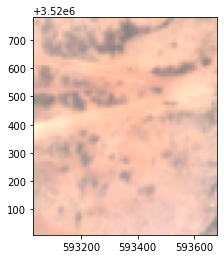

Processing file: gs://gcp-public-data-sentinel-2/tiles/13/S/ER/S2A_MSIL1C_20191003T173151_N0208_R055_T13SER_20191003T210918.SAFE
 
         gs://gcp-public-data-sentinel-2/tiles/13/S/ER/S2A_MSIL1C_20191003T173151_N0208_R055_T13SER_20191003T210918.SAFE
         Transform: | 10.00, 0.00, 593030.00|
| 0.00,-10.00, 3520780.00|
| 0.00, 0.00, 1.00|
         Shape: (13, 77, 65)
         Resolution: (10.0, 10.0)
         Bounds: (593030.0, 3520010.0, 593680.0, 3520780.0)
         CRS: EPSG:32613
         bands: ['B04', 'B03', 'B02']
         fill_value_default: 0
        


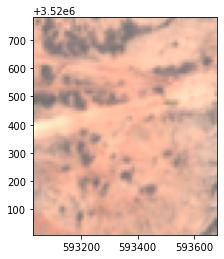

Processing file: gs://gcp-public-data-sentinel-2/tiles/13/S/ER/S2B_MSIL1C_20190928T173109_N0208_R055_T13SER_20190928T205958.SAFE
 
         gs://gcp-public-data-sentinel-2/tiles/13/S/ER/S2B_MSIL1C_20190928T173109_N0208_R055_T13SER_20190928T205958.SAFE
         Transform: | 10.00, 0.00, 593030.00|
| 0.00,-10.00, 3520780.00|
| 0.00, 0.00, 1.00|
         Shape: (13, 77, 65)
         Resolution: (10.0, 10.0)
         Bounds: (593030.0, 3520010.0, 593680.0, 3520780.0)
         CRS: EPSG:32613
         bands: ['B04', 'B03', 'B02']
         fill_value_default: 0
        


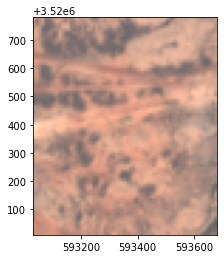

CPU times: user 5.9 s, sys: 1 s, total: 6.9 s
Wall time: 1min 59s


In [31]:
%%time
import numpy as np
from georeader import read
import rasterio.plot as rstplt

for product in products_gpd.title:
    s2_safe_folder = S2_SAFE_reader.s2_public_bucket_path(product+".SAFE", check_exists=True)
    print(f"Processing file: {s2_safe_folder}")
    s2obj = S2_SAFE_reader.s2loader(s2_safe_folder, out_res=10)
    s2obj.bands = ["B04", "B03", "B02"]
    data = read.read_from_bounds(s2obj, bounds_read, crs_bounds=crs_bounds, 
                                 pad_add=(20,20)) # This does not trigger the download of the data
    print(repr(data))
    
    data_memory = data.load() # this trigger read
    # TODO do ToA conversion depending on metadata
    rstplt.show(np.clip((data_memory.values)/3_000,0,1), transform=data.transform)

## Appendix: Sentinel-2 grid

Sentinel-2 images are distributed in an uniform grid where each Sentinel-2 product (tile) comprises 100 x 100 km². This grid is the [Military Grid Reference System](https://en.wikipedia.org/wiki/Military_Grid_Reference_System). You can see the grid for Sentinel-2 products [here](https://eatlas.org.au/data/uuid/f7468d15-12be-4e3f-a246-b2882a324f59#:~:text=This%20dataset%20shows%20the%20tiling,European%20Space%20Agency%20(ESA).). 

We have downloaded that grid and saved it in a Google bucket.

In [29]:
%%time

# S2 grid obtained from https://github.com/justinelliotmeyers/Sentinel-2-Shapefile-Index
s2grid = gpd.read_file("gs://starcop/S2/sentinel_2_index_shapefile.shp")

# This takes a while, if we use it very frequently perhaps it's worth to cache it
s2grid = s2grid.set_index("Name")
s2grid

CPU times: user 2.89 s, sys: 347 ms, total: 3.23 s
Wall time: 9.14 s


,geometry
Name,
01CCV,"POLYGON Z ((180.00000 -73.05974 0.00000, 176.8..."
01CCV,"POLYGON Z ((-180.00000 -72.07333 0.00000, -179..."
01CDH,"POLYGON Z ((180.00000 -83.80855 0.00000, 174.7..."
01CDH,"POLYGON Z ((-180.00000 -82.82590 0.00000, -176..."
01CDJ,"POLYGON Z ((180.00000 -82.91344 0.00000, 175.7..."
...,...
60XWP,"POLYGON Z ((-180.00000 80.13994 0.00000, -177...."
60XWQ,"POLYGON Z ((180.00000 80.05179 0.00000, 176.99..."
60XWQ,"POLYGON Z ((-180.00000 81.03542 0.00000, -176...."


In [30]:
s2grid.loc["13SER"] # Sanity check the tile name is in the grid tiles

geometry    POLYGON Z ((-105.00021 32.53736 0.00000, -103....
Name: 13SER, dtype: geometry